In [26]:
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import image, plotting
from pathlib import Path
import matplotlib.pyplot as plt
import re
import glob

In [ ]:

# --- PATHS ---
# FMRIPREP_ROOT = Path("/neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep")
FMRIPREP_ROOT = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/fmriprep")

EVENTS_DIR    = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/events")
LOGS_DIR      = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/log")
SEQ_DIR       = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/seq")
RESULTS_DIR   = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/results_industrial")


# --- SETTINGS ---
TASK, SPACE = "motif4limbs", "MNI152NLin2009cAsym",


In [23]:
# --- GET THE FILES ---
def get_motif_files(sub_id):
    """Strictly finds motif4limbs tasks and extracts run/dir."""
    func_dir = FMRIPREP_ROOT / f"sub-{sub_id}" / "func"
    # Ensure we use the exact task name
    pattern = f"sub-{sub_id}_task-{TASK}_dir-*_run-*_space-{SPACE}_desc-preproc_bold.nii.gz"
    bolds = sorted(func_dir.glob(pattern))
    
    run_data = []
    for b in bolds:
        # Improved Regex to catch 'dir' and 'run'
        run_match = re.search(r"run-(\d+)", b.name)
        dir_match = re.search(r"dir-([a-z]+)", b.name)
        
        if run_match and dir_match:
            run_num = run_match.group(1)
            direc = dir_match.group(1)
            
            run_data.append({
                "run": run_num,
                "dir": direc,
                "bold": b,
                "mask": func_dir / b.name.replace("desc-preproc_bold.nii.gz", "desc-brain_mask.nii.gz"),
                "conf": func_dir / b.name.replace(f"space-{SPACE}_desc-preproc_bold.nii.gz", "desc-confounds_timeseries.tsv")
            })
    return run_data




# --- THE AUDIT FUNCTION ---
def audit_subject(sub_id, data_runs):
    """
    Reads header info for a single subject and returns a pandas DataFrame.
    """
    report_data = []
    
    for r in data_runs:
        try:
            img = nib.load(str(r['bold']))
            header = img.header
            zooms = header.get_zooms()
            
            # Gather Key Info
            info = {
                "Subject": sub_id,
                "Run_ID": r['run'],
                "Dimensions (x,y,z)": img.shape[:3],
                "TimePoints (N_scans)": img.shape[3],
                "TR (sec)": round(zooms[3], 3),
                "Voxel Size (mm)": f"{zooms[0]:.2f}x{zooms[1]:.2f}x{zooms[2]:.2f}",
                "Duration (min)": round((img.shape[3] * zooms[3]) / 60, 1)
            }
            report_data.append(info)
        except Exception as e:
            print(f"❌ Error reading Run {r['run']}: {e}")

    return pd.DataFrame(report_data)

# --- THE VISUALIZATION FUNCTION (Generates Images) ---
def plot_qc_images(sub_id, data_runs):
    """
    Plots the Mean and Standard Deviation (Noise) map for every run 
    directly in the notebook.
    """
    print(f"\n🧠 VISUAL QC: Subject {sub_id}")
    print("="*60)
    
    for r in data_runs:
        bold_path = r['bold']
        run_id = r['run']
        
        # Load image
        img = nib.load(str(bold_path))
        
        # Create a figure with 2 subplots (Left: Mean, Right: Noise)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # A. Mean Image (Check for Dropout/Blur)
        mean_img = image.mean_img(img)
        plotting.plot_epi(
            mean_img, 
            title=f"Run {run_id}: MEAN (Anatomy)",
            display_mode='z', 
            cut_coords=5, # Shows 5 slices along the Z-axis
            axes=axes[0],
            colorbar=False
        )
        
        # B. T-STD Image (Check for Motion/Artifacts)
        # We calculate standard deviation across time
        data = img.get_fdata()
        std_vol = np.std(data, axis=3)
        std_img = nib.Nifti1Image(std_vol, img.affine)
        
        plotting.plot_epi(
            std_img,
            title=f"Run {run_id}: NOISE (Motion Check)",
            display_mode='z',
            cut_coords=5,
            cmap='magma', # Hot colors = High Noise
            axes=axes[1],
            colorbar=True
        )
        
        plt.show() # Renders the plot in the notebook immediately

In [25]:
subjects_to_analyze = ["01", "02", "03"]
print(f"Queue: {len(subjects_to_analyze)} subjects ready for Audit.")

all_reports = []

for sub in subjects_to_analyze:
    # 1. Get the file paths using your existing function
    data_runs = get_motif_files(sub)
    
    # 2. Run the Audit
    df = audit_subject(sub, data_runs)
    
    # 3. Display the Table nicely
    print(f"\n📋 REPORT: SUBJECT {sub}")
    display(df)  # 'display()' makes a pretty HTML table in Jupyter
    
    # Check for consistency warnings
    if df['TimePoints (N_scans)'].nunique() > 1:
        print("⚠️ WARNING: Mismatch in number of scans between runs!")
    if df['TR (sec)'].nunique() > 1:
        print("⚠️ CRITICAL: TR mismatch found!")

    all_reports.append(df)

# Optional: Combine everything into one big master table
# master_df = pd.concat(all_reports)

Queue: 3 subjects ready for Audit.

📋 REPORT: SUBJECT 01


,Subject,Run_ID,"Dimensions (x,y,z)",TimePoints (N_scans),TR (sec),Voxel Size (mm),Duration (min)
0,01,01,"(101, 125, 107)",406,1.6,1.50x1.50x1.50,10.8
1,01,03,"(101, 125, 107)",406,1.6,1.50x1.50x1.50,10.8
2,01,02,"(101, 125, 107)",406,1.6,1.50x1.50x1.50,10.8



📋 REPORT: SUBJECT 02


,Subject,Run_ID,"Dimensions (x,y,z)",TimePoints (N_scans),TR (sec),Voxel Size (mm),Duration (min)
0,02,01,"(101, 125, 107)",360,1.6,1.50x1.50x1.50,9.6
1,02,03,"(101, 125, 107)",360,1.6,1.50x1.50x1.50,9.6
2,02,02,"(101, 125, 107)",360,1.6,1.50x1.50x1.50,9.6



📋 REPORT: SUBJECT 03


,Subject,Run_ID,"Dimensions (x,y,z)",TimePoints (N_scans),TR (sec),Voxel Size (mm),Duration (min)
0,03,01,"(101, 125, 107)",360,1.6,1.50x1.50x1.50,9.6
1,03,02,"(101, 125, 107)",360,1.6,1.50x1.50x1.50,9.6


In [ ]:
# Execute Visual Inspection
for sub in subjects_to_analyze:
    data_runs = get_motif_files(sub)
    plot_qc_images(sub, data_runs)


🧠 VISUAL QC: Subject 01


📂 Reading: motif-stroke_sub-1_run-2_events.tsv
First 5 rows (Raw Time in ms):


,onset,duration,trial_type
0,63957,14741.0,pied_gauche
1,78698,5313.0,fix
2,84011,14750.0,pied_droit
3,98761,5312.0,fix
4,104073,14740.0,main_droite


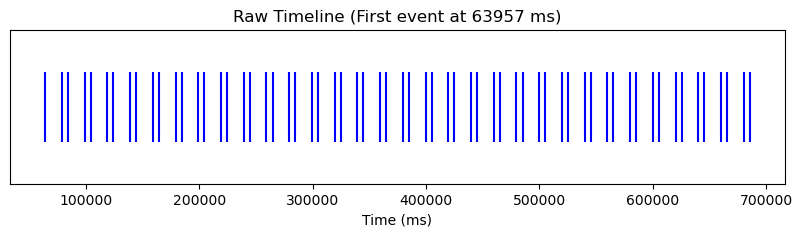

In [62]:

# SETTINGS
SUB = "sub-1"
RUN = "2"

# 1. Load File
event_file = list(EVENTS_DIR.glob(f"*{SUB}*run-{RUN}_events.tsv"))[0]
df_events = pd.read_csv(event_file, sep='\t')

print(f"📂 Reading: {event_file.name}")
print(f"First 5 rows (Raw Time in ms):")
display(df_events.head())

# 2. Simple Plot
plt.figure(figsize=(10, 2))
# Plot every trial as a vertical line
plt.eventplot(df_events['onset'], orientation='horizontal', colors='blue')
plt.title(f"Raw Timeline (First event at {df_events['onset'].min()} ms)")
plt.xlabel("Time (ms)")
plt.yticks([])
plt.show()

In [63]:
# 1. Load File
log_file = list(LOGS_DIR.glob(f"*{SUB}*run-{RUN}*.csv"))[0]
df_log = pd.read_csv(log_file)

print(f"📂 Reading: {log_file.name}")

# 2. Find the TTL (The Trigger)
# We just look for the row where event is 'TTL'
ttl_row = df_log[df_log['event'] == 'TTL']

print("\nScanning Start Time (TTL):")
display(ttl_row.head(1))

# Save this number for later!
ttl_time = ttl_row.iloc[0]['time']
print(f"👉 WE MUST SUBTRACT {ttl_time} FROM EVERYTHING.")

📂 Reading: motif-stroke_sub-1_run-2_2025-11-21_15-41-49.csv

Scanning Start Time (TTL):


,time,event
1,63454,TTL


👉 WE MUST SUBTRACT 63454 FROM EVERYTHING.


In [ ]:

# 1. Load File
seq_file = list(SEQ_DIR.glob(f"*run-{RUN}*.csv"))[0]
df_seq = pd.read_csv(seq_file)

print(f"📂 Reading: {seq_file.name}")

# 2. Show the Block Order
# We group by block_id to see the unique blocks
blocks = df_seq.groupby('block_id').first()

print("\nTheoretical Block Order:")
display(blocks[['block_name']].head(10))

📂 Reading: stim_sequence_run-2.csv

Theoretical Block Order:


,block_name
block_id,
0,pied_gauche
1,pied_droit
2,main_droite
3,main_gauche
4,main_gauche
5,main_droite
6,pied_droit
7,pied_gauche
8,pied_droit
